In [19]:
from ultra import visuals as v
from ultra.visuals import make_matplotlib_pretty_again 
from ultra import dataframe 
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt 
import numpy as np
import sys 
import os 
_DATADIR_ = os.environ["DATA_DIRECTORY"]

In [2]:
Vishnu = dataframe("%sVishnu/Vishnu_z0p0_200particle.hlist" % (_DATADIR_), 
                 labels = ["pid", "spinh", "spinb", "mvir", "vmax", "mpeak", "vpeak"], 
                columns = [5, 26, 45, 10, 16, 61, 63]) 
ConsueloHD = dataframe("%sConsueloHD/ConsueloHD_z0p0_200particle.hlist" % (_DATADIR_), 
                 labels = ["pid", "spinh", "spinb", "mvir", "vmax", "mpeak", "vpeak"], 
                columns = [5, 26, 45, 10, 16, 61, 63]) 

In [3]:
def get_mass_sample(raw, bin_edges): 
    """
    Filters the data sample into a mass bin 
    
    Parameters 
    ========== 
    raw :: ultra.dataframe 
        The dataframe holding the halos 
    bin_edges :: 2-element python list of real numbers 
    
    Returns 
    ======= 
    filtered :: ultra.dataframe 
        A new dataframe containing only the masses in the 
        logarithmic bin, whose edges are passed to this 
        function 
    """
    filtered = raw.sieve("mvir", ">=", 10**bin_edges[0]) 
    filtered = filtered.sieve("mvir", "<=", 10**bin_edges[1]) 
    return filtered 

def which(mass): 
    """
    Returns one of the datasets based on a fiducial mass 
    
    Parameters 
    ========== 
    mass :: real number 
        The log10 of the halo mass in Msun/h 
        
    Returns 
    ======= 
    The Vishnu dataset if mass <= 12 and ConsueloHD otherwise 
    """
    if mass <= 12: 
        return Vishnu 
    else: 
        return ConsueloHD 

In [4]:
mass_bins = [[10.9, 11.1], [11.9, 12.1], [12.9, 13.1]] 
for i in mass_bins: 
    print("Median Vmax in km/s in the 10^%g Msun/h bin: %e" % (np.mean(i), 
        np.median(get_mass_sample(which(np.mean(i)), i)["vmax"])))

Median Vmax in km/s in the 10^11 Msun/h bin: 7.970000e+01
Median Vmax in km/s in the 10^12 Msun/h bin: 1.626800e+02
Median Vmax in km/s in the 10^13 Msun/h bin: 3.458400e+02


Median Vmax in 10^11 Msun/h bin: 79.700 km/s 

Median Vmax in 10^12 Msun/h bin: 162.68 km/s 

Median Vmax in 10^13 Msun/h bin: 345.84 km/s     

In [27]:
def draw_distribution(axes, data, masskey, spinkey, spinbins, massbin, color, log = True): 
    xvals = list(map(lambda x, y: (x + y) / 2, spinbins[:-1], spinbins[1:])) 
    hosts = data.sieve("pid", "==", -1) 
    subs = data.sieve("pid", ">", 0) 
    if log: 
        hosts = hosts.sieve(masskey, ">=", 10**massbin[0]) 
        hosts = hosts.sieve(masskey, "<=", 10**massbin[1]) 
        subs = subs.sieve(masskey, ">=", 10**massbin[0]) 
        subs = subs.sieve(masskey, "<=", 10**massbin[1]) 
    else: 
        hosts = hosts.sieve(masskey, ">=", massbin[0]) 
        hosts = hosts.sieve(masskey, "<=", massbin[1]) 
        subs = subs.sieve(masskey, ">=", massbin[0]) 
        subs = subs.sieve(masskey, "<=", massbin[1]) 
    hosts_counts = hosts.hist(spinkey, spinbins) 
    subs_counts = subs.hist(spinkey, spinbins) 
#     hosts_counts = [i / hosts.size[0] if hosts.size[0] != 0 else 0 for i in hosts_counts] 
#     subs_counts = [i / subs.size[0] if hosts.size[0] != 0 else 0 for i in subs_counts] 
    hosts_counts = normalize(hosts_counts, spinbins) 
    subs_counts = normalize(subs_counts, spinbins) 
    diff = list(map(lambda x, y: x - y, subs_counts, hosts_counts)) 
    axes[0].plot(xvals, hosts_counts, linestyle = ':', c = v.colors()[color]) 
    axes[0].plot(xvals, subs_counts, linestyle = '-', c = v.colors()[color]) 
    axes[1].plot(xvals, diff, linestyle = '-', c = v.colors()[color]) 
#     axes[1].plot(xvals, len(xvals) * [0], c = v.colors()["black"], linestyle = '--') 
    
def normalize(counts, bins): 
    norm = 0 
    for i in range(len(counts)): 
        norm += counts[i] * (bins[i + 1] - bins[i]) 
    return list(map(lambda x: x / norm, counts))

In [13]:
def draw_legend(axes, key, bins, colors, log = True): 
    lines = len(bins) * [None] 
    qty = {
        "mvir":      r"$M_\text{vir}$", 
        "mpeak":     r"$M_\text{peak}$", 
        "vmax":      r"$V_\text{max}$", 
        "vpeak":     r"$V_\text{peak}$" 
    }[key.lower()]
    for i in range(len(bins)): 
        if log: 
            lines[i] = axes[0].plot([0., 0.1], [0.1, 0.], 
                label = r"%s = $10^{%g \pm %g}\ h^{-1}\ M_\odot$" % (
                    qty, np.mean(bins[i]), (bins[i][1] - bins[i][0]) / 2
                )
            )[0]
        else: 
            lines[i] = axes[0].plot([0., 0.1], [0.1, 0.], 
                label = r"%s = $%g \pm %g\ km\ s^{-1}$" % (
                    qty, np.mean(bins[i]), (bins[i][1] - bins[i][0]) / 2), 
                c = v.colors()["white"])[0]
    leg = axes[0].legend(loc = v.mpl_loc("lower left"), bbox_to_anchor = (0.02, 0.02), ncol = 1, 
        frameon = False, handlelength = 0, fontsize = 20) 
    for i in range(len(lines)): 
        lines[i].remove() 
        leg.get_texts()[i].set_color(colors[i]) 
        
        

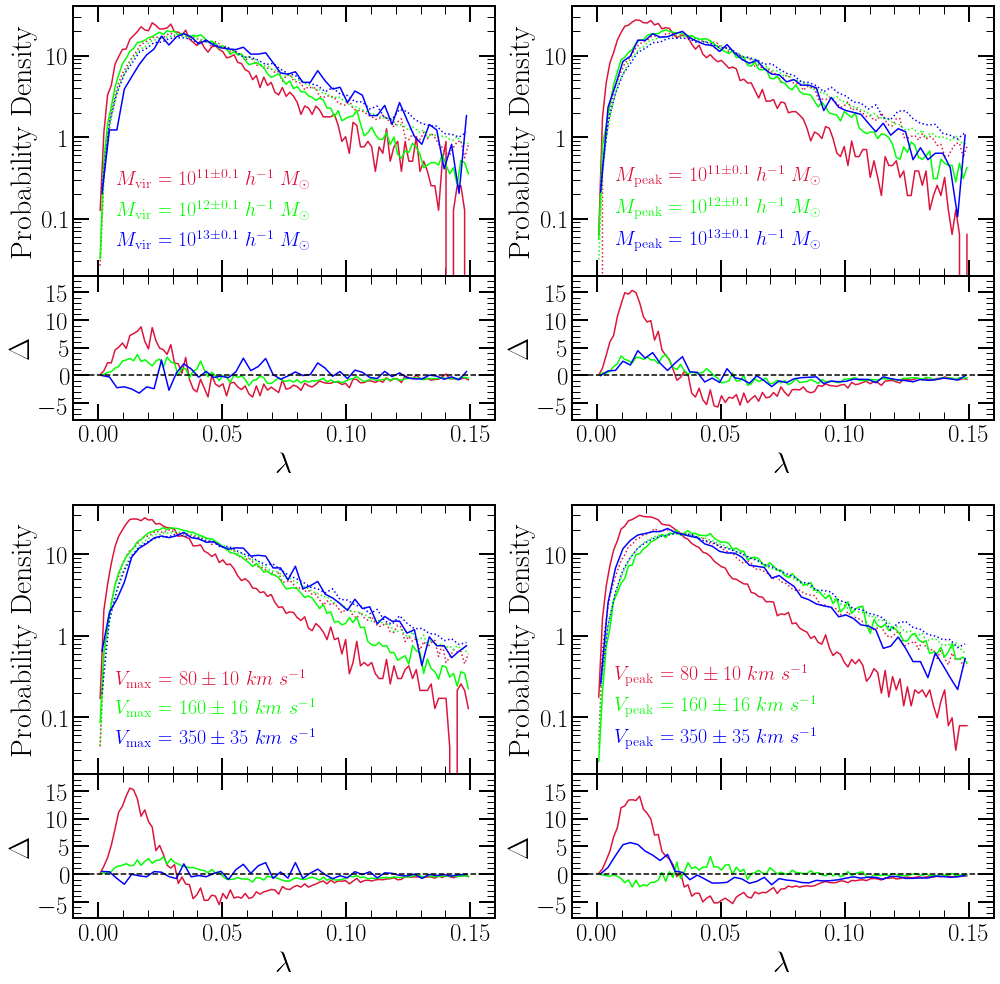

In [29]:
# xlabels = [[r"$M_\text{vir}\ [h^{-1}\ M_\odot]$", r"$M_\text{peak}\ [h^{-1}\ M_\odot]$"], 
#           [r"$V_\text{max}\ [km\ s^{-1}]$", r"$V_\text{peak}\ [km\ s^{-1}]$"]]
fig = plt.figure(figsize = (14, 14))  
axes = 2 * [None] 
for i in range(2): 
    axes[i] = 2 * [None] 
    for j in range(2): 
        axes[i][j] = 2 * [None] 
        axes[i][j][0] = fig.add_subplot(221 + 2 * i + j, facecolor = "white") 
        axes[i][j][1] = v.append_subplot_below(axes[i][j][0], 2.0, pad = 0, sharex = axes[i][j][0])  
        axes[i][j][1].set_xlabel(r"$\lambda$") 
        axes[i][j][1].set_ylabel(r"$\Delta$") 
        axes[i][j][0].set_ylabel("Probability Density")
        axes[i][j][0].set_yscale("log") 
        v.hide_xticklabels(axes[i][j][0]) 

spin_bins_fine = np.linspace(0, 0.15, 101) 
spin_bins_coarse = np.linspace(0, 0.15, 51)
draw_distribution(axes[0][0], Vishnu, "mvir", "spinb", spin_bins_fine, [10.9, 11.1], "crimson") 
draw_distribution(axes[0][0], ConsueloHD, "mvir", "spinb", spin_bins_fine, [11.9, 12.1], "lime") 
draw_distribution(axes[0][0], ConsueloHD, "mvir", "spinb", spin_bins_coarse, [12.9, 13.1], "blue") 
draw_distribution(axes[0][1], Vishnu, "mpeak", "spinb", spin_bins_fine, [10.9, 11.1], "crimson") 
draw_distribution(axes[0][1], ConsueloHD, "mpeak", "spinb", spin_bins_fine, [11.9, 12.1], "lime") 
draw_distribution(axes[0][1], ConsueloHD, "mpeak", "spinb", spin_bins_coarse, [12.9, 13.1], "blue") 
draw_distribution(axes[1][0], Vishnu, "vmax", "spinb", spin_bins_fine, [70, 90], "crimson", log = False) 
draw_distribution(axes[1][0], ConsueloHD, "vmax", "spinb", spin_bins_fine, [144, 176], "lime", log = False) 
draw_distribution(axes[1][0], ConsueloHD, "vmax", "spinb", spin_bins_coarse, [315, 385], "blue", log = False) 
draw_distribution(axes[1][1], Vishnu, "vpeak", "spinb", spin_bins_fine, [70, 90], "crimson", log = False) 
draw_distribution(axes[1][1], ConsueloHD, "vpeak", "spinb", spin_bins_fine, [144, 176], "lime", log = False) 
draw_distribution(axes[1][1], ConsueloHD, "vpeak", "spinb", spin_bins_coarse, [315, 385], "blue", log = False) 

draw_legend(axes[0][0], "mvir", [[10.9, 11.1], [11.9, 12.1], [12.9, 13.1]], ["crimson", "lime", "blue"]) 
draw_legend(axes[0][1], "mpeak", [[10.9, 11.1], [11.9, 12.1], [12.9, 13.1]], ["crimson", "lime", "blue"]) 
draw_legend(axes[1][0], "vmax", [[70, 90], [144, 176], [315, 385]], ["crimson", "lime", "blue"], log = False) 
draw_legend(axes[1][1], "vpeak", [[70, 90], [144, 176], [315, 385]], ["crimson", "lime", "blue"], log = False) 

for i in range(2): 
    for j in range(2): 
#         v.yticklabel_formatter(axes[i][j][0]) 
        axes[i][j][1].plot([-0.01, 0.16], [0, 0], linestyle = '--', c = v.colors()["black"]) 
        axes[i][j][0].yaxis.set_major_formatter(fsf("%g")) 
        axes[i][j][0].set_ylim([0.02, 40]) 
        axes[i][j][1].set_ylim([-8, 18]) 
        axes[i][j][1].set_xlim([-0.01, 0.16]) 
        axes[i][j][1].yaxis.set_ticks([-5, 0, 5, 10, 15]) 
plt.tight_layout() 
plt.savefig("histograms.pdf") 